In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
import tensorflow.keras as keras
np.set_printoptions(precision = 4)

2023-01-13 14:01:06.065573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path_clean_power = "./data/clean_competitor_market_prices_power.csv"
path_master_market = "./data/master_market.csv"

In [4]:
dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str}
usecols = [name for name, _ in dtypes.items()]

In [5]:
household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)

In [6]:
market = pd.read_csv(path_master_market, header = [0], parse_dates=["date"]).drop("Unnamed: 0", axis=1)
market.set_index("date", inplace = True)

In [7]:
market.interpolate(method = "time", axis = 0, inplace = True)

In [8]:
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]

In [9]:
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])

In [10]:
postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [11]:
def queryRangePostCode(df_power, consumption_range_kwh = 2000, post_code = "81737") -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [12]:
postCodes

array(['14480', '31789', '55118', '17489', '28259', '53229', '8058',
       '4229', '31137', '33102', '34125', '38640', '42897', '48429',
       '51381', '51469', '65197', '78054', '1309', '12627', '19061',
       '37085', '58452', '64289', '67063', '68309', '74078', '76137',
       '81737', '85055', '89075', '6110', '8523', '9130', '22844',
       '23558', '26133', '27753', '33332', '33613', '38226', '41238',
       '44339', '44866', '45481', '51103', '90459', '39108', '41462',
       '41751', '42719', '44625', '58636', '69126', '72762', '75181',
       '79110', '3046', '7549', '7743', '21423', '22159', '38120',
       '38448', '40625', '42277', '45355', '45899', '46049', '47798',
       '52066', '56070', '57072', '58135', '63069', '72108', '90763',
       '6844', '18109', '24109', '27578', '30419', '44575', '45665',
       '46238', '47137', '47441', '48161', '49082', '54294', '59071',
       '60439', '66113', '67663', '70499', '86179', '93049', '97084',
       '99089', '71638'], dtyp

In [13]:
df = queryRangePostCode(household, 3500, "12627")
input = df.join(market[["spot", "d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
input.drop(["2022-10-14", "2022-10-15"], inplace=True)

In [14]:
input

,price_kwh,spot,d01,d02,M01,M02,M03,q01,q02,y01,y02
valid_range,,,,,,,,,,,
2021-07-28,0.288009,0.079422,0.04610,0.07444,0.08132,0.08738,0.08769,0.09082,0.08792,0.07408,0.06511
2021-07-29,0.288695,0.046097,0.06481,0.03013,0.08410,0.08931,0.08978,0.09277,0.08917,0.07524,0.06552
2021-07-30,0.288695,0.064806,0.02982,0.06030,0.08329,0.08845,0.08909,0.09186,0.08841,0.07498,0.06528
2021-07-31,0.288695,0.029823,0.05854,0.08010,0.09195,0.09261,0.09869,0.09513,0.09071,0.07684,0.06681
2021-08-01,0.288695,0.058535,0.08010,0.09651,0.09195,0.09261,0.09869,0.09513,0.09071,0.07684,0.06681
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-09,0.819596,0.146725,0.16209,0.25987,0.34489,0.39041,0.54793,0.48409,0.36300,0.42700,0.27000
2022-10-10,0.822353,0.162090,0.25987,0.30167,0.34489,0.39041,0.54793,0.48409,0.36300,0.42700,0.27000
2022-10-11,0.855141,0.259874,0.28254,0.25562,0.34531,0.38275,0.56462,0.50137,0.37100,0.43564,0.27000


<AxesSubplot: xlabel='valid_range'>

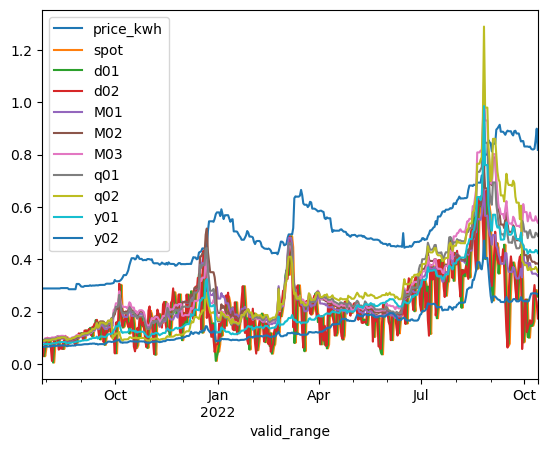

In [15]:
input.plot()

In [16]:
n = len(input)
train_df = input[:int(0.7*n)]
val_df = input[int(0.7*n):int(0.9*n)]
test_df = input[int(0.9*n):]

In [17]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(310, 11)
(88, 11)
(45, 11)


In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
def plot(self, model=None, plot_col='price_kwh', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [21]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Baseline

In [23]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['price_kwh'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['price_kwh']

In [24]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [25]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2023-01-13 14:01:59.992622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 14:01:59.997927: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


3/3 [==============================] - 0s 3ms/step - loss: 1.7833e-04 - mean_absolute_error: 0.0066


In [26]:
print(performance, val_performance)

{'Baseline': [0.000384280807338655, 0.010774732567369938]} {'Baseline': [0.00017832720186561346, 0.006633942015469074]}


In [27]:
wide_window = WindowGenerator(
    input_width=10, label_width=10, shift=1,
    label_columns=['price_kwh'])

wide_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['price_kwh']

In [28]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 10, 11)
Output shape: (32, 10, 1)


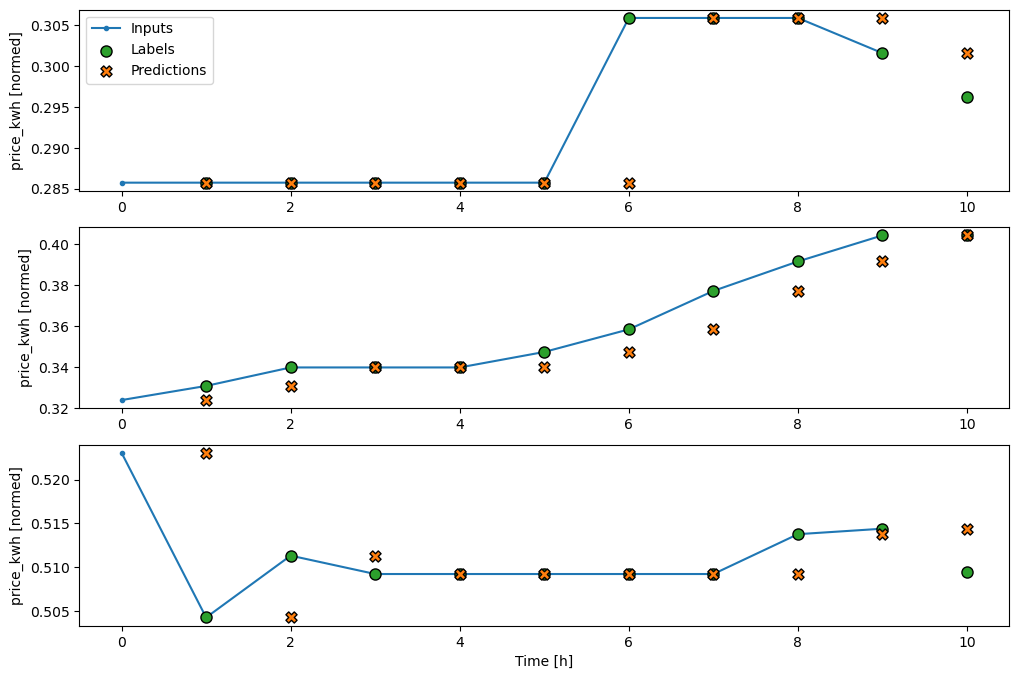

In [29]:
wide_window.plot(baseline)

# Linear Model

In [30]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [31]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 11)
Output shape: (32, 1, 1)


In [32]:
MAX_EPOCHS = 25

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [33]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/25
10/10 [==============================] - 1s 29ms/step - loss: 0.6732 - mean_absolute_error: 0.8002 - val_loss: 1.1921 - val_mean_absolute_error: 1.0722
Epoch 2/25
10/10 [==============================] - 0s 12ms/step - loss: 0.6222 - mean_absolute_error: 0.7687 - val_loss: 1.0792 - val_mean_absolute_error: 1.0207
Epoch 3/25
10/10 [==============================] - 0s 10ms/step - loss: 0.5738 - mean_absolute_error: 0.7376 - val_loss: 0.9735 - val_mean_absolute_error: 0.9699
Epoch 4/25
10/10 [==============================] - 0s 10ms/step - loss: 0.5276 - mean_absolute_error: 0.7070 - val_loss: 0.8754 - val_mean_absolute_error: 0.9202
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.4850 - mean_absolute_error: 0.6771 - val_loss: 0.7836 - val_mean_absolute_error: 0.8711
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.4443 - mean_absolute_error: 0.6475 - val_loss: 0.6997 - val_mean_absolute_error: 0.8236
Epoch 7/25
10/10 [======

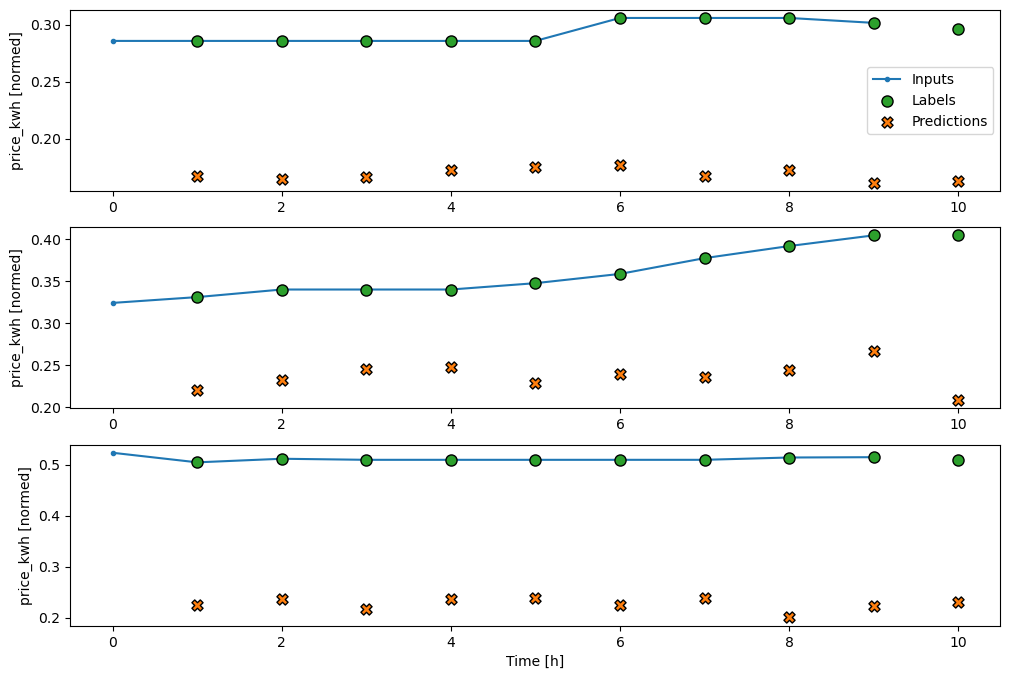

In [34]:
wide_window.plot(linear)

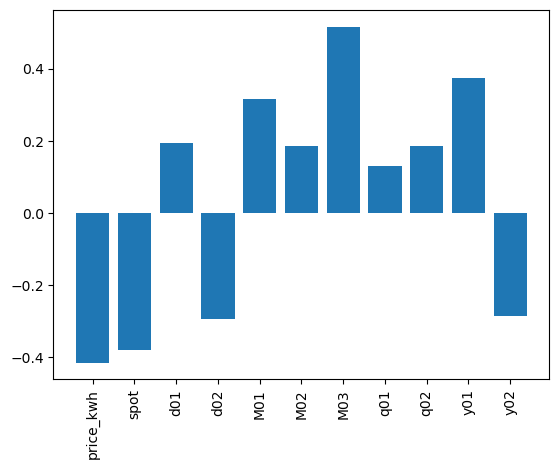

In [35]:
#Print weights of linear model
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [36]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/25
10/10 [==============================] - 2s 53ms/step - loss: 0.1524 - mean_absolute_error: 0.3702 - val_loss: 0.0404 - val_mean_absolute_error: 0.1974
Epoch 2/25
10/10 [==============================] - 0s 32ms/step - loss: 0.0209 - mean_absolute_error: 0.1178 - val_loss: 0.0384 - val_mean_absolute_error: 0.1657
Epoch 3/25
10/10 [==============================] - 0s 35ms/step - loss: 0.0093 - mean_absolute_error: 0.0732 - val_loss: 0.0758 - val_mean_absolute_error: 0.2468
Epoch 4/25
10/10 [==============================] - 0s 40ms/step - loss: 0.0061 - mean_absolute_error: 0.0590 - val_loss: 0.0201 - val_mean_absolute_error: 0.1149
Epoch 5/25
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mean_absolute_error: 0.0472 - val_loss: 0.0093 - val_mean_absolute_error: 0.0717
Epoch 6/25
10/10 [==============================] - 0s 27ms/step - loss: 0.0030 - mean_absolute_error: 0.0417 - val_loss: 0.0168 - val_mean_absolute_error: 0.1068
Epoch 7/25
3/3 [======

In [37]:
performance

{'Baseline': [0.000384280807338655, 0.010774732567369938],
 'Linear': [0.14125417172908783, 0.3618837594985962],
 'Dense': [0.003999668639153242, 0.04688534513115883]}

# Multi Step Dense

In [38]:
CONV_WIDTH = 5
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['price_kwh'])

conv_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['price_kwh']

Text(0.5, 1.0, 'Given 5 hours of inputs, predict 1 hour into the future.')

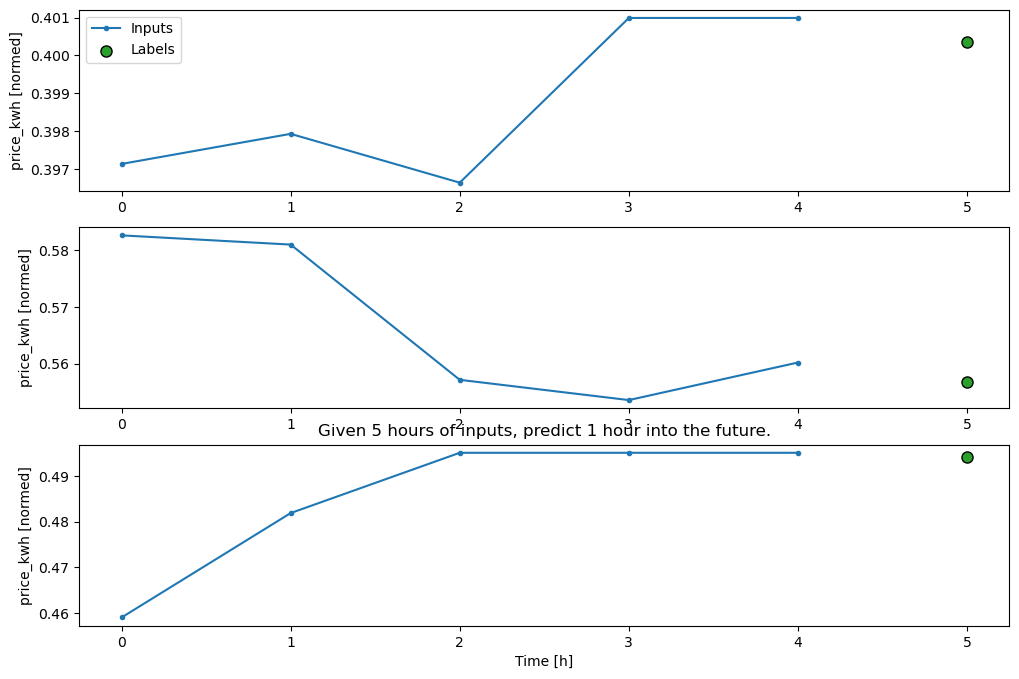

In [39]:
conv_window.plot()
plt.title("Given 5 hours of inputs, predict 1 hour into the future.")


In [40]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [41]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 5, 11)
Output shape: (32, 1, 1)


In [42]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)


Epoch 1/25
10/10 [==============================] - 2s 61ms/step - loss: 0.1096 - mean_absolute_error: 0.2859 - val_loss: 0.0024 - val_mean_absolute_error: 0.0359
Epoch 2/25
10/10 [==============================] - 0s 35ms/step - loss: 0.0097 - mean_absolute_error: 0.0811 - val_loss: 0.0737 - val_mean_absolute_error: 0.2600
Epoch 3/25
3/3 [==============================] - 0s 18ms/step - loss: 0.0095 - mean_absolute_error: 0.0883


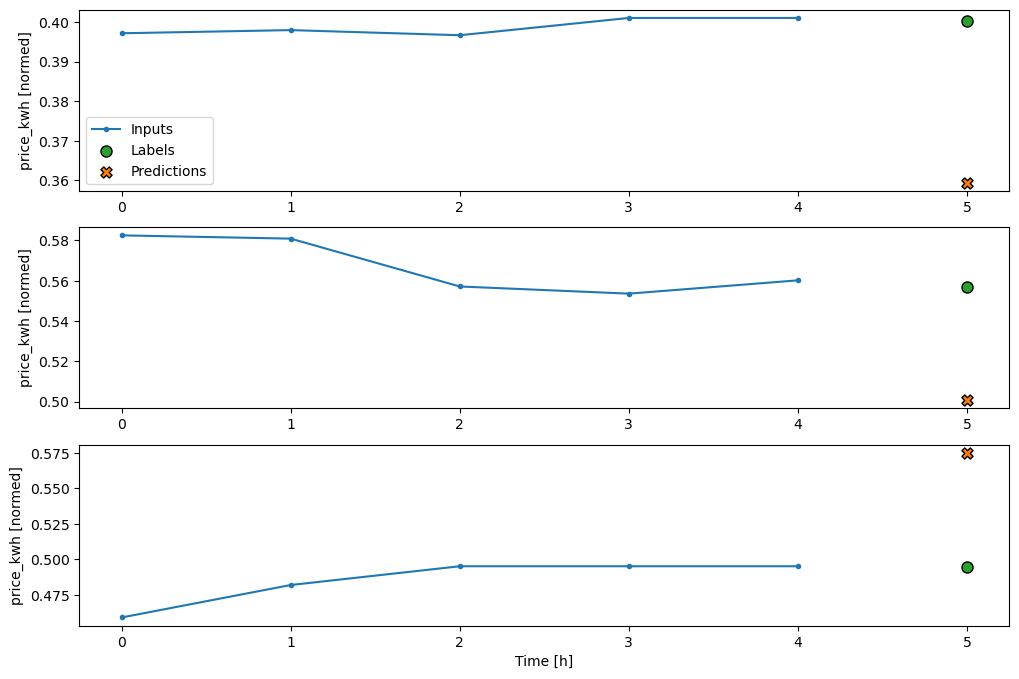

In [43]:
conv_window.plot(multi_step_dense)

In [44]:
performance

{'Baseline': [0.000384280807338655, 0.010774732567369938],
 'Linear': [0.14125417172908783, 0.3618837594985962],
 'Dense': [0.003999668639153242, 0.04688534513115883],
 'Multi step dense': [0.006603742949664593, 0.06741505861282349]}

# Convolutional Model

In [45]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [46]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 5, 11)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


Epoch 1/25
10/10 [==============================] - 2s 64ms/step - loss: 0.0505 - mean_absolute_error: 0.1915 - val_loss: 0.0550 - val_mean_absolute_error: 0.1984
Epoch 2/25
10/10 [==============================] - 0s 38ms/step - loss: 0.0079 - mean_absolute_error: 0.0631 - val_loss: 0.1281 - val_mean_absolute_error: 0.3212
Epoch 3/25
10/10 [==============================] - 1s 33ms/step - loss: 0.0057 - mean_absolute_error: 0.0526 - val_loss: 0.0378 - val_mean_absolute_error: 0.1609
Epoch 4/25
10/10 [==============================] - 1s 34ms/step - loss: 0.0048 - mean_absolute_error: 0.0554 - val_loss: 0.0372 - val_mean_absolute_error: 0.1606
Epoch 5/25
10/10 [==============================] - 1s 47ms/step - loss: 0.0032 - mean_absolute_error: 0.0427 - val_loss: 0.0450 - val_mean_absolute_error: 0.1828
Epoch 6/25
10/10 [==============================] - 1s 38ms/step - loss: 0.0024 - mean_absolute_error: 0.0360 - val_loss: 0.0282 - val_mean_absolute_error: 0.1428
Epoch 7/25
10/10 [====

In [48]:
val_performance

{'Baseline': [0.00017832720186561346, 0.006633942015469074],
 'Linear': [0.03022538684308529, 0.16084922850131989],
 'Dense': [0.01349138654768467, 0.09496995806694031],
 'Multi step dense': [0.009460845962166786, 0.08825735747814178],
 'Conv': [0.007723589893430471, 0.07554759085178375]}

In [49]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 10, 11)
Labels shape: (32, 10, 1)
Output shape: (32, 6, 1)


In [50]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['price_kwh'])

wide_conv_window

Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Label column name(s): ['price_kwh']

In [51]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 28, 11)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


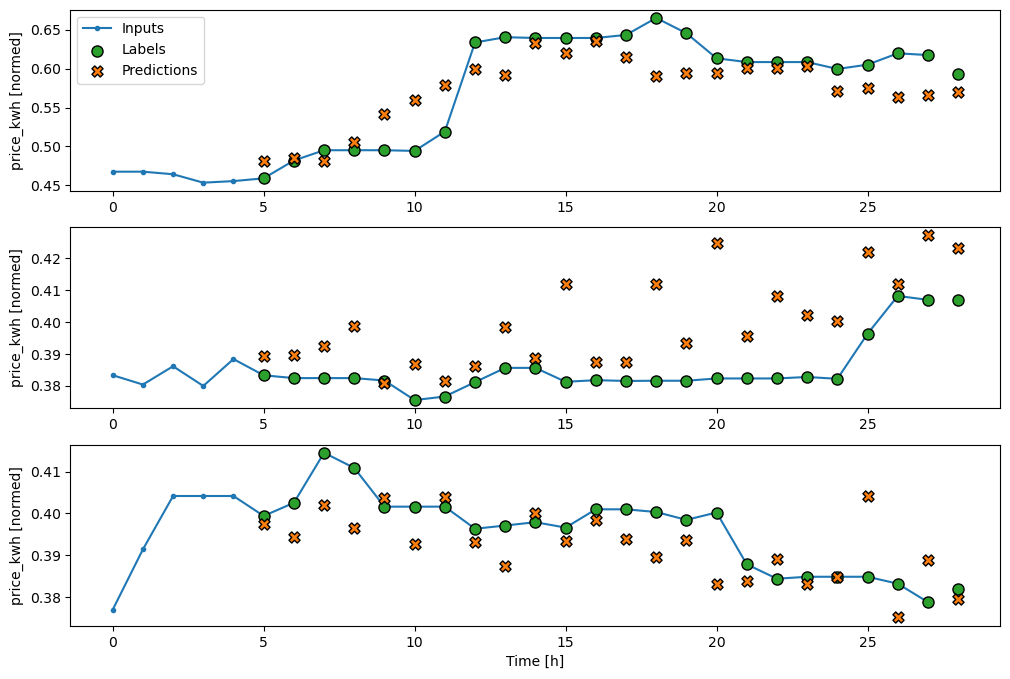

In [52]:
wide_conv_window.plot(conv_model)

# LSTM Model

In [53]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [54]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 10, 11)
Output shape: (32, 10, 1)


In [55]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/25
10/10 [==============================] - 5s 162ms/step - loss: 0.0671 - mean_absolute_error: 0.2300 - val_loss: 0.0430 - val_mean_absolute_error: 0.1752
Epoch 2/25
10/10 [==============================] - 1s 78ms/step - loss: 0.0304 - mean_absolute_error: 0.1377 - val_loss: 0.0865 - val_mean_absolute_error: 0.2566
Epoch 3/25
10/10 [==============================] - 1s 115ms/step - loss: 0.0243 - mean_absolute_error: 0.1212 - val_loss: 0.0396 - val_mean_absolute_error: 0.1729
Epoch 4/25
10/10 [==============================] - 1s 72ms/step - loss: 0.0200 - mean_absolute_error: 0.1032 - val_loss: 0.0278 - val_mean_absolute_error: 0.1421
Epoch 5/25
10/10 [==============================] - 1s 92ms/step - loss: 0.0171 - mean_absolute_error: 0.0945 - val_loss: 0.0314 - val_mean_absolute_error: 0.1556
Epoch 6/25
3/3 [==============================] - 0s 26ms/step - loss: 0.0303 - mean_absolute_error: 0.1545


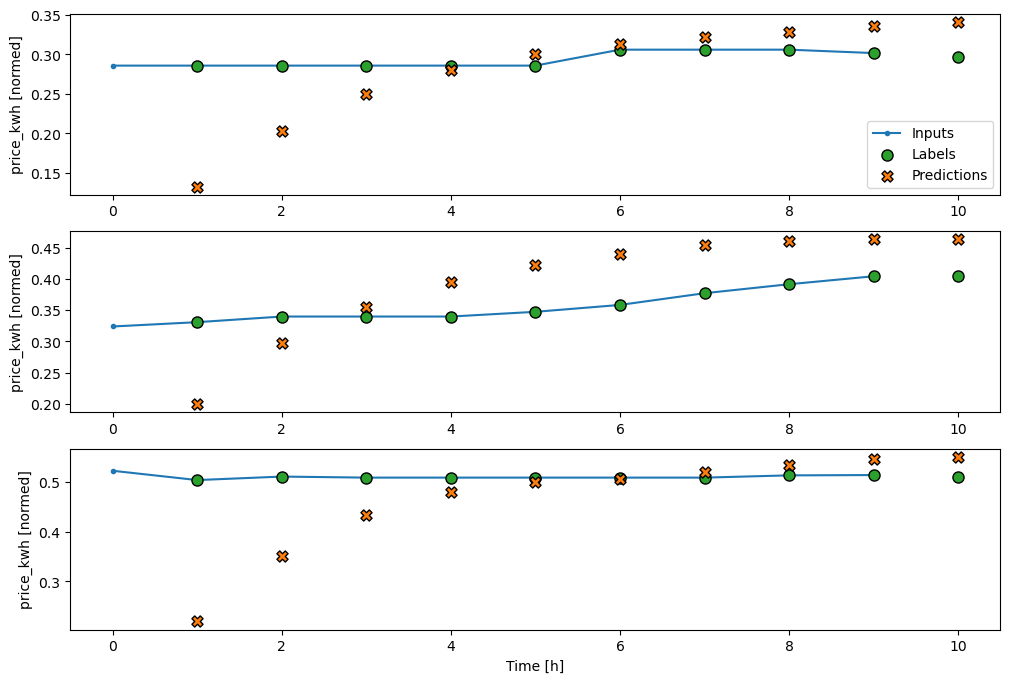

In [56]:
wide_window.plot(lstm_model)


#  LSTM + Dense

In [57]:
lstm_DNN_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(16),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [58]:
monthly_window = WindowGenerator(input_width=30, label_width=1, shift=1, label_columns=["price_kwh"])
monthly_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['price_kwh']

In [59]:
print('Input shape:', monthly_window.example[0].shape)
print('Output shape:', lstm_DNN_model(monthly_window.example[0]).shape)

Input shape: (32, 30, 11)
Output shape: (32, 30, 1)


In [60]:
history = compile_and_fit(lstm_DNN_model, monthly_window)

val_performance['LSTM+Dense'] = lstm_DNN_model.evaluate(monthly_window.val)
performance['LSTM+Dense'] = lstm_DNN_model.evaluate(monthly_window.test, verbose=0)

Epoch 1/25
9/9 [==============================] - 7s 232ms/step - loss: 0.0725 - mean_absolute_error: 0.2237 - val_loss: 0.0332 - val_mean_absolute_error: 0.1388
Epoch 2/25
9/9 [==============================] - 1s 104ms/step - loss: 0.0247 - mean_absolute_error: 0.1376 - val_loss: 0.0257 - val_mean_absolute_error: 0.1183
Epoch 3/25
9/9 [==============================] - 1s 91ms/step - loss: 0.0131 - mean_absolute_error: 0.0766 - val_loss: 0.0309 - val_mean_absolute_error: 0.1314
Epoch 4/25
9/9 [==============================] - 1s 129ms/step - loss: 0.0117 - mean_absolute_error: 0.0673 - val_loss: 0.0209 - val_mean_absolute_error: 0.0926
Epoch 5/25
9/9 [==============================] - 1s 101ms/step - loss: 0.0094 - mean_absolute_error: 0.0660 - val_loss: 0.0165 - val_mean_absolute_error: 0.0830
Epoch 6/25
9/9 [==============================] - 1s 109ms/step - loss: 0.0086 - mean_absolute_error: 0.0652 - val_loss: 0.0161 - val_mean_absolute_error: 0.0791
Epoch 7/25
9/9 [=============

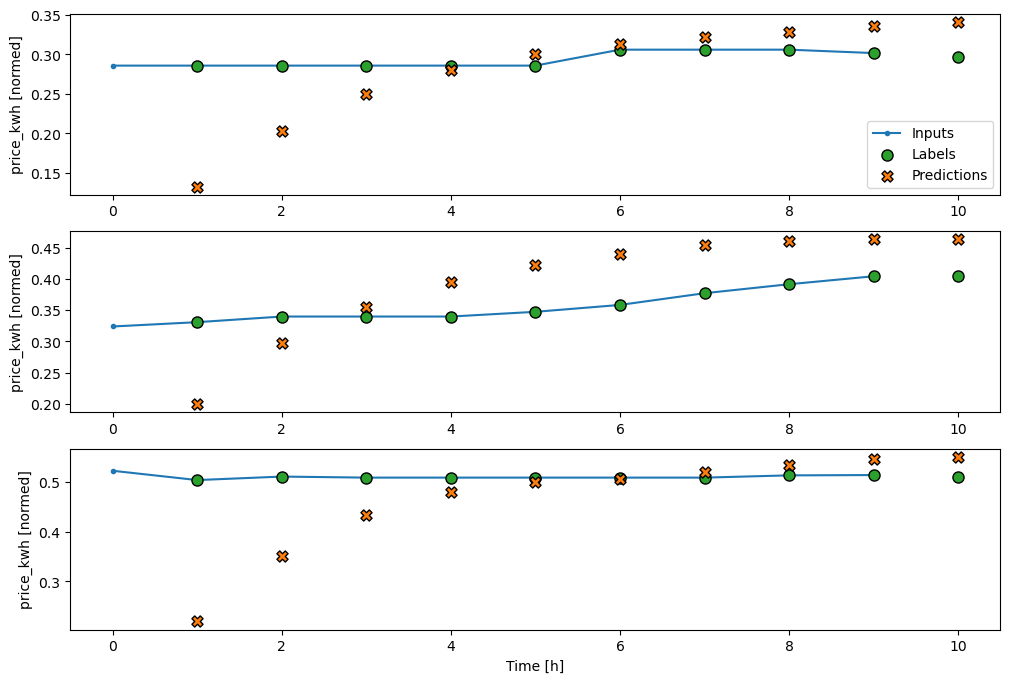

In [61]:
wide_window.plot(lstm_model)


# Performance

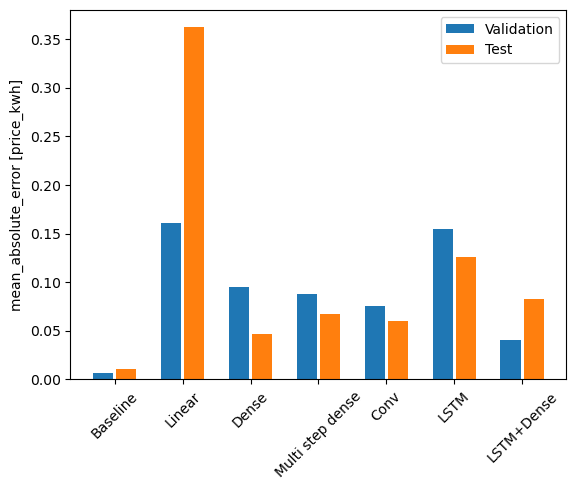

In [62]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [price_kwh]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [63]:
lstm_model.metrics_names

['loss', 'mean_absolute_error']

In [64]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.0108
Linear      : 0.3619
Dense       : 0.0469
Multi step dense: 0.0674
Conv        : 0.0595
LSTM        : 0.1259
LSTM+Dense  : 0.0824
